# Chess in Python

Here I'll be working towards creating a chess engine using deep learning.

## Simulating Chess Matches

I want to start off by creating a chess match simulator. This will be what the engine will interact with in order to train. First thing we do here is import the necessary packages and demonstrate a bit of how they work.

In [1]:
import chess
import chess.pgn

In [2]:
game = chess.pgn.Game()
board = game.board()

In [3]:
game.headers

OrderedDict([('Event', '?'),
             ('Site', '?'),
             ('Date', '????.??.??'),
             ('Round', '?'),
             ('White', '?'),
             ('Black', '?'),
             ('Result', '*')])

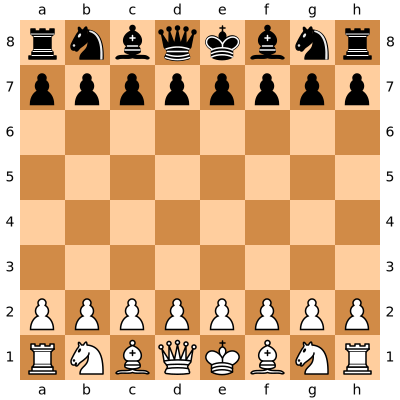

In [4]:
board

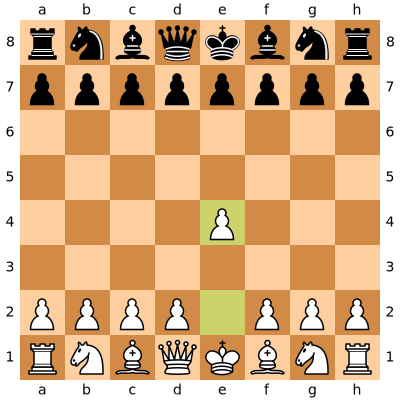

In [5]:
board.push(chess.Move.from_uci("e2e4"))
board

In [6]:
board.reset_board()

Pretty straightforward. Next we create a program that simulates random chess games where the moves are selected uniformly at random.

In [7]:
def simulate_game():
    
    def get_current_time():
        from datetime import datetime
        return datetime.strftime(datetime.now(), "%Y/%m/%d %H:%M:%S.%f")
    
    def initialise_game():
        game = chess.pgn.Game()
        board = game.board()
        game.headers['Date'] = get_current_time()
        game.headers['Black'] = 'Random Agent'
        game.headers['White'] = 'Random Agent'
        return game, board
    
    def get_next_move():
        from random import sample
        return sample(list(board.legal_moves), 1)[0]
        
    game, board = initialise_game()
    next_move = get_next_move()
    node = game.add_variation(next_move)
    board.push(next_move)
    while not board.is_game_over():
        next_move = get_next_move()
        node = node.add_variation(next_move)
        board.push(next_move)
    
    game.headers['result'] = board.result()
    
    return game, board

[Event "?"]
[Site "?"]
[Date "2017/11/14 09:02:36.781894"]
[Round "?"]
[White "Random Agent"]
[Black "Random Agent"]
[Result "*"]
[result "1/2-1/2"]

1. d4 f6 2. b3 b6 3. h4 g6 4. f4 e5 5. a4 e4 6. Kd2 d6 7. Ra3 Ba6 8. g3 Bg7 9. a5 Bc4 10. Ke1 Bd5 11. c3 h5 12. Ra2 Nc6 13. Bb2 Qe7 14. g4 Rh7 15. Kf2 Bxb3 16. Qxb3 Ne5 17. Qc4 Nd7 18. Qd3 c5 19. Nh3 Nf8 20. Qd1 f5 21. Ra3 hxg4 22. Bg2 Qf6 23. a6 Ke7 24. Bf1 Ke6 25. Bc1 Bh8 26. Ng1 Ke7 27. Bd2 Qxh4+ 28. Ke3 Rb8 29. Nh3 Rg7 30. Qc1 Rd8 31. Qe1 Qxe1 32. Bxe1 Rc8 33. Ng5 Ne6 34. Nh3 Nd8 35. Nf2 Nf7 36. Ra2 Rd8 37. Nd3 Rb8 38. Bf2 Nfh6 39. Rg1 Rb7 40. axb7 Nf7 41. Rg2 Kd7 42. Nb2 Ng5 43. Nd1 Rh7 44. Bg1 Kc6 45. Ra1 Rc7 46. Kd2 b5 47. Bh2 Kd7 48. Ra6 Nh7 49. Rg3 Rxb7 50. Ke3 b4 51. Rf3 Ke8 52. Rxd6 Nhf6 53. Rxf6 Rf7 54. cxb4 Nxf6 55. Kf2 Nh5 56. Na3 Re7 57. Rd3 Bf6 58. Kg1 Rc7 59. Nf2 Kd7 60. Rg3 Bg7 61. Rc3 Bh6 62. Rh3 Ng7 63. bxc5 gxh3 64. Bg3 a6 65. Kh2 Nh5 66. Nxe4 g5 67. Nc4 Rxc5 68. Be1 a5 69. Nc3 Bg7 70. Bh4 Ke8 71. Ne5 Ke7 72. Nd1 gxh4

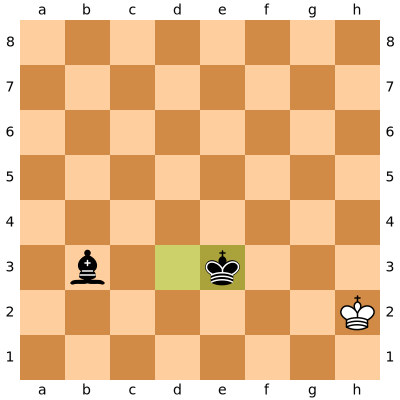

In [8]:
game, board = simulate_game()
print(game)
board

## Featurising Chess

Now that we can successfully simulate a random chess game, the next job is to turn the board position into a set of features that can be fed into a machine learning algorithm. In this part, I will take inspiration from the AlphaGo Zero model.

In [9]:
import numpy as np

We want to one-hot encode the positions of each piece on the board. As the package is written, board positions are stored using 64 bit integers. In order to repackage the board positions as a numpy array, we need to write a function to convert them.

In [10]:
def int_to_mask(squares):
    '''Takes a set of squares as an integer and returns an 8x8 matrix of the marked squares'''
    # convert int to binary
    squares = np.binary_repr(squares, width=64)
    # break int string into one-hot array
    squares = np.array([i for i in squares])
    # reshape into 8 by 8 matrix
    squares = squares.reshape(8,8)
    # flip along y axis (for some reason)
    squares = squares[:,::-1]
    # change type to int
    squares = squares.astype(np.int0)
    return squares

Now we can use `int_to_mask` to express where each piece on the board is as a numpy array.

In [11]:
int_to_mask(board.pieces_mask(color=chess.BLACK, piece_type=chess.KING))

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

We compare our result with the board below.

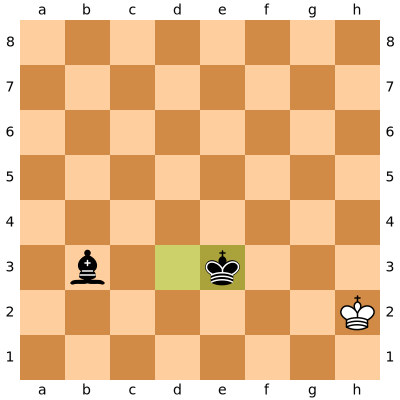

In [12]:
board

## Featurising the board position

In order to create features for the deep learning model, we will arrange the board position as a stack of `8 x 8` arrays. We will create one-hot encoded layers for each unique piece type and colour. The order of the first 12 layers will be as follows:

- White Pawn
- White Knight
- White Bishop
- White Rook
- White Queen
- White King

- Black Pawn
- Black Knight
- Black Bishop
- Black Rook
- Black Queen
- Black King

We can repeat this stack 4 times to store the past few moves on the board. This will be necessary to give the model the ability to detect 'En Passant'.

We will also add one more layer to indicate which rooks on the board are still capable of castling. And one last layer to indicate if it is the white player's turn.

That makes `12 x 4 + 2 = 50` layers over all, totalling `3200` input values.

## Building the Feature Matrix

Now I'll write the code to build the first `14` layers of the model from the game board.

In [13]:
input_data = np.zeros(shape = (14, 8, 8))
for i, colour in enumerate(chess.COLORS):
    for j, piece in enumerate(chess.PIECE_TYPES):
        k = i * len(chess.PIECE_TYPES) + j
        input_data[k, :, :] = int_to_mask(board.pieces_mask(color=colour, piece_type=piece))
        print(input_data[k, :, :])
        print()

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 

Next we add the castling information:

In [14]:
input_data[k + 1, :, :] = int_to_mask(board.castling_rights)
input_data[k + 1, :, :]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

And lastly whose turn it is.

In [15]:
input_data[k + 2, :, :] = board.turn * np.ones((8, 8))
input_data[k + 2, :, :]

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

Now we package these operations into a function that can generate the feature matrix for a given board.

In [ ]:
def featurise_board(board):
    board_data = np.zeros(shape = (12, 8, 8))
    for i, colour in enumerate(chess.COLORS):
        for j, piece in enumerate(chess.PIECE_TYPES):
            k = i * len(chess.PIECE_TYPES) + j
            piece_location = board.pieces_mask(color=colour, piece_type=piece)
            board_data[k, :, :] = int_to_mask(piece_location)
    return board_data

## Defining the Foward Pass

Now that we have a sensible feature set, we have to create a model architecture, and then perform a forward pass with a random initialisation to make sure that the model output is well defined. Ideally, we would like to implement a Deep Residual Network. 

Once we have that, we will be able to start working on the Markov Chain Monte Carlo (MCMC) Tree Search implementation, and also the training loop for the model.

Some useful resources:
- https://codesachin.wordpress.com/2017/02/19/residual-neural-networks-as-ensembles/
- https://blog.waya.ai/deep-residual-learning-9610bb62c355

## What is a Move?

Before we can define the forward pass, we have define our target output. We want the model to map board positions to moves on the board, so we need a way to express what a particular move on the board looks like to the neural network.

All moves in chess are performed by selecting a piece, and moving it to a new square. At the same time that a piece is moved, there can be side-effects on the board (e.g. a piece capture, or another piece may move as in castling). This means that the target output can simply be a selection of a piece in one location, along with the target location where the piece has been moved.

This means we can represent moves via an `64 x 64 = 4096` array where moves are given as ordered pairs of squares on the board (i.e. a 'from' square to select the piece on that square and a 'target' square to select where the piece is moving).

However, we also need to add 4 more output parameters as well to describe pawn promotion. This is because when a pawn promotes to the other side of the board, the model will need to select which piece (Queen, Rook, Bishop or Knight) the AI will choose to replace the pawn. This makes for `5000` output parameters, which is quite a lot more than I would have expected.

If I can think of ways to simplify the output parameter space later, then I will. This large search space strikes me as unparsimonious.

In [ ]:
import tensorflow as tf